In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [8]:
import pandas as pd
import imp
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri

RANDOM_SEED = 0
numpy2ri.activate()
ro.r('set.seed({})'.format(RANDOM_SEED))

import fairtest.utils.log as fairtest_log
imp.reload(fairtest_log)
fairtest_log.set_params(filename='fairtest.log')

In [9]:
import fairtest.utils.prepare_data as prepare
from fairtest import DataSource
import fairtest.investigation as inv
import fairtest.testing as testing
import fairtest.discovery as discovery
import fairtest.error_profiling as error_profiling
import fairtest.modules.metrics as metrics
import fairtest.modules.metrics.correlation as correlation
import fairtest.modules.metrics.regression as regression
import fairtest.modules.metrics.binary_metrics as binary_metrics
import fairtest.modules.statistics.confidence_interval as intervals
import ast
import sklearn.preprocessing as preprocessing


dataname = 'movies'

# Testing Investigation on Movie Ratings
data = prepare.data_from_csv( '../data/recommender/recommendations.txt', sep='\\t')

# prepare age
data['Age'] = map(lambda a: 10 if a == 1 
                       else 20 if a == 18 
                       else 30 if a == 25 
                       else 40 if a == 35 
                       else 50 if a == 45 or a == 50
                       else 60 if a == 56 else None, data['Age'])

data['Avg Seen Rating'] = ['low' if x < np.mean(data['Avg Seen Rating']) 
                               else 'high' for x in data['Avg Seen Rating']]

data_source = DataSource(data)


#
# Test of associations on movie popularity
#
SENS = ['Gender', 'Age']
TARGET = 'Avg Recommended Rating'
EXPL = []

test_ratings = testing.Testing(data_source, SENS, TARGET, EXPL, random_state=RANDOM_SEED,
                               to_drop=['RMSE', 'Avg Movie Age', 'Types', 'Avg Seen Rating'])

#
# Test of associations on movie popularity conditioned on error
#
SENS = ['Gender', 'Age']
TARGET = 'Avg Recommended Rating'
EXPL = ['Avg Seen Rating']

test_ratings_expl = testing.Testing(data_source, SENS, TARGET, EXPL, random_state=RANDOM_SEED,
                               to_drop=['RMSE', 'Avg Movie Age', 'Types'])

investigations = [test_ratings, test_ratings_expl]

INFO:root:Encoding Feature Gender
INFO:root:Encoding Feature Occupation
INFO:root:Encoding Feature Avg Seen Rating
INFO:root:Encoding Feature Types
INFO:root:Training Size 3020
INFO:root:Testing Sizes [3020]
INFO:root:New Testing Investigation
INFO:root:Target Feature: Target(names=['Avg Recommended Rating'], arity=None)
INFO:root:Choosing metric CORR for feature Gender
INFO:root:Choosing metric CORR for feature Age
INFO:root:New Testing Investigation
INFO:root:Target Feature: Target(names=['Avg Recommended Rating'], arity=None)
INFO:root:Choosing metric CondCORR for feature Gender
INFO:root:Choosing metric CondCORR for feature Age


In [10]:
import fairtest.modules.context_discovery.guided_tree as guided_tree
imp.reload(guided_tree)
inv.train(investigations, score_aggregation='avg', min_leaf_size=100, max_depth=5)

INFO:root:Begin training phase with protected feature Gender
INFO:root:Building a Guided Decision Tree
INFO:root:splitting on Age (score=0.0125493711137) with threshold 55.0 at pred []
INFO:root:splitting on Age (score=0.0234501133104) with threshold 45.0 at pred ['Age <= 55.0']
INFO:root:Begin training phase with protected feature Age
INFO:root:Building a Guided Decision Tree
INFO:root:splitting on Gender (score=0.116354311568) with threshold None at pred []
INFO:root:splitting on Occupation (score=0.0129418779096) with threshold None at pred ['Gender = 1']
INFO:root:Begin training phase with protected feature Gender
INFO:root:Building a Guided Decision Tree
INFO:root:splitting on Age (score=0.0010284170772) with threshold 45.0 at pred []
INFO:root:Begin training phase with protected feature Age
INFO:root:Building a Guided Decision Tree
INFO:root:splitting on Gender (score=0.0294821297603) with threshold None at pred []
INFO:root:splitting on Occupation (score=0.00257057204616) with t

In [11]:
import fairtest.modules.statistics.hypothesis_test as tests
import fairtest.modules.statistics.multiple_testing as multitest
import fairtest.modules.context_discovery.tree_parser as tree_parser
import fairtest.modules.statistics.confidence_interval as intervals
imp.reload(tests)
imp.reload(multitest)
imp.reload(tree_parser)
imp.reload(intervals)

inv.test(investigations, exact=True, prune_insignificant=True)

INFO:root:Parsing tree for sensitive feature Gender...
INFO:root:Parsed tree for sensitive feature Gender
INFO:root:Parsing tree for sensitive feature Age...
INFO:root:Parsed tree for sensitive feature Age
INFO:root:Parsing tree for sensitive feature Gender...
INFO:root:Parsed tree for sensitive feature Gender
INFO:root:Parsing tree for sensitive feature Age...
INFO:root:Parsed tree for sensitive feature Age
INFO:root:Begin testing phase
INFO:root:Testing 9 hypotheses
INFO:root:Computing stats for 5 contexts
INFO:root:Computing stats for context 0
INFO:root:Computing stats for context 1
INFO:root:Computing stats for context 4
INFO:root:Computing stats for context 7
INFO:root:Computing stats for context 2
INFO:root:Computing stats for 4 contexts
INFO:root:Computing stats for context 0
INFO:root:Computing stats for context 1
INFO:root:Computing stats for context 3
INFO:root:Computing stats for context 4
INFO:root:Testing 18 hypotheses
INFO:root:Computing stats for 4 contexts
INFO:root:Co

Report Creation time: 2016-07-18 09:05:04

Dataset: movies
Train Size: 3020
Test Size: 3020
S: ['Gender', 'Age']
X: ['Occupation']
E: None
O: ['Avg Recommended Rating']

Train Params: 	{'max_bins': 10, 'min_leaf_size': 100, 'max_depth': 5, 'agg_type': 'avg'}
Test Params: 	{'prune_insignificant': True, 'exact': True, 'family_conf': 0.95}
Report Params: 	{'node_filter': 'better_than_ancestors'}

Report of associations of O=['Avg Recommended Rating'] on Si = Gender:
Association metric: CORR

Global Population 0 of size 3020



/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/figure.py:1595: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


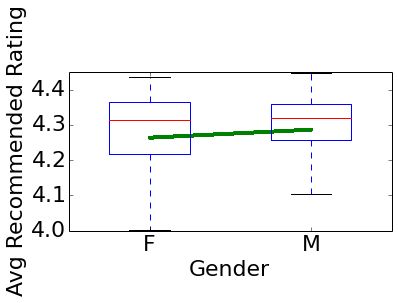

INFO:root:Filtering and ranking 4 sub-contexts
INFO:root:3 statistically significant sub-contexts
INFO:root:Size range: 511-2834
INFO:root:1 sub-contexts printed


p-value = 2.72e-04 ; CORR = [0.0204, 0.1286]

Sub-Population 4 of size 511
Context = {'Age': (45.0, 55.0]}



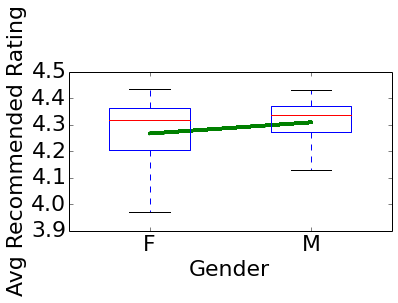

p-value = 6.00e-04 ; CORR = [0.0271, 0.3077]
--------------------------------------------------------------------------------

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [0.0204, 0.1286] ; Size = 3020
   Context = {'Age': (45.0, 55.0]} ; CI = [0.0271, 0.3077] ; Size = 511
--------------------------------------------------------------------------------

Report of associations of O=['Avg Recommended Rating'] on Si = Age:
Association metric: CORR

Global Population 0 of size 3020



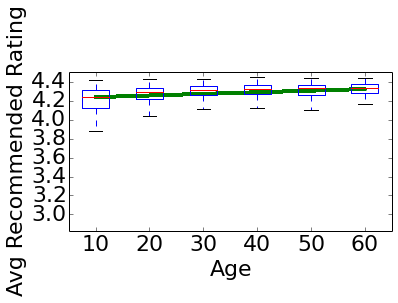

INFO:root:Filtering and ranking 5 sub-contexts
INFO:root:2 statistically significant sub-contexts
INFO:root:Size range: 846-2174
INFO:root:1 sub-contexts printed


p-value = 1.19e-16 ; CORR = [0.1007, 0.2069]

Sub-Population 1 of size 2174
Context = {'Gender': 'M'}



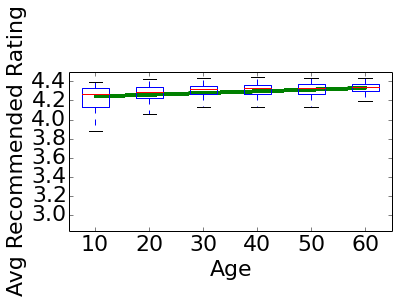

p-value = 4.98e-15 ; CORR = [0.1089, 0.2333]
--------------------------------------------------------------------------------

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [0.1007, 0.2069] ; Size = 3020
   Context = {'Gender': 'M'} ; CI = [0.1089, 0.2333] ; Size = 2174
--------------------------------------------------------------------------------

Report Creation time: 2016-07-18 09:05:05

Dataset: movies
Train Size: 3020
Test Size: 3020
S: ['Gender', 'Age']
X: ['Occupation']
E: Avg Seen Rating
O: ['Avg Recommended Rating']

Train Params: 	{'max_bins': 10, 'min_leaf_size': 100, 'max_depth': 5, 'agg_type': 'avg'}
Test Params: 	{'prune_insignificant': True, 'exact': True, 'family_conf': 0.95}
Report Params: 	{'node_filter': 'better_than_ancestors'}

Report of associations of O=['Avg Recommended Rating'] on Si = Gender:
Association metric: CondCORR

Global Population 0 of size 3020

> Avg Seen Rating = high ; size 1553 (51.42%):


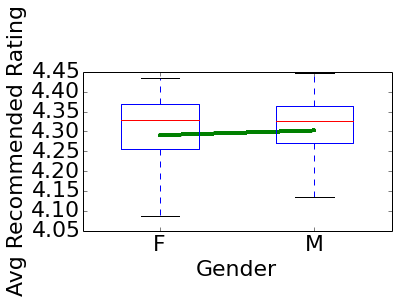

p-value = 4.34e-01 ; CORR = [-0.0310, 0.1306]

> Avg Seen Rating = low ; size 1467 (48.58%):


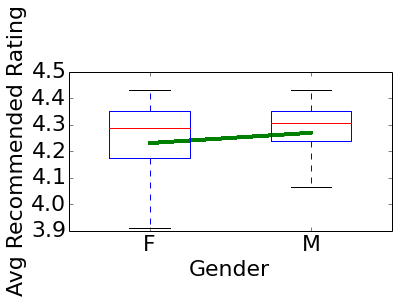

INFO:root:Filtering and ranking 2 sub-contexts
INFO:root:0 statistically significant sub-contexts
INFO:root:0 sub-contexts printed


p-value = 4.76e-04 ; CORR = [0.0238, 0.1887]

p-value = 2.48e-01 ; CondCORR = [-0.0044, 0.1588]

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [-0.0044, 0.1588] ; Size = 3020
--------------------------------------------------------------------------------

Report of associations of O=['Avg Recommended Rating'] on Si = Age:
Association metric: CondCORR

Global Population 0 of size 3020

> Avg Seen Rating = high ; size 1553 (51.42%):


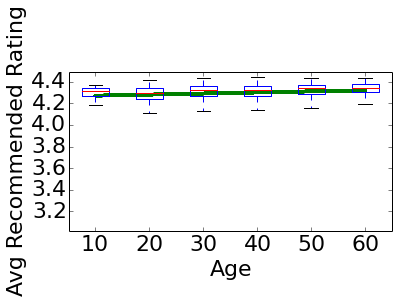

p-value = 1.19e-04 ; CORR = [0.0315, 0.1915]

> Avg Seen Rating = low ; size 1467 (48.58%):


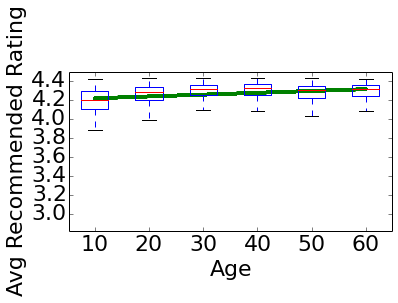

INFO:root:Filtering and ranking 4 sub-contexts
INFO:root:1 statistically significant sub-contexts
INFO:root:Size range: 2174-2174
INFO:root:1 sub-contexts printed


p-value = 5.29e-07 ; CORR = [0.0613, 0.2246]

p-value = 6.61e-05 ; CondCORR = [0.0460, 0.2076]

Sub-Population 1 of size 2174
Context = {'Gender': 'M'}

> Avg Seen Rating = high ; size 1093 (50.28%):


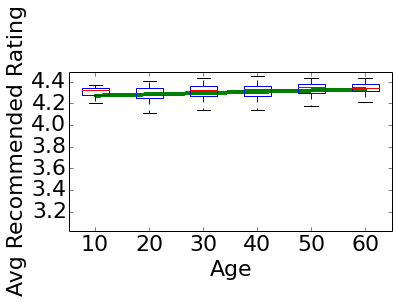

p-value = 2.82e-05 ; CORR = [0.0475, 0.2366]

> Avg Seen Rating = low ; size 1081 (49.72%):


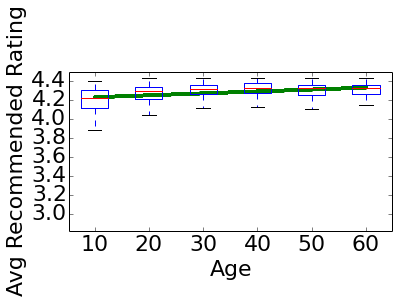

p-value = 1.44e-06 ; CORR = [0.0657, 0.2548]

p-value = 1.58e-05 ; CondCORR = [0.0565, 0.2456]
--------------------------------------------------------------------------------

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [0.0460, 0.2076] ; Size = 3020
   Context = {'Gender': 'M'} ; CI = [0.0565, 0.2456] ; Size = 2174
--------------------------------------------------------------------------------



In [6]:
import fairtest.modules.bug_report.report as rep
import fairtest.modules.bug_report.filter_rank as fr
imp.reload(rep)
imp.reload(fr)

output_dir = '../results'
#output_dir = None
inv.report(investigations, dataname, filter_conf=0.95, output_dir=None, node_filter=fr.FILTER_BETTER_THAN_ANCESTORS)